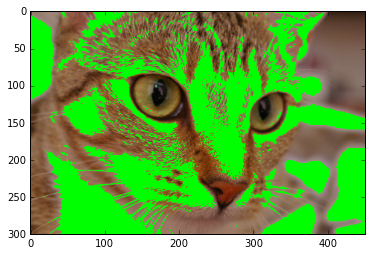

In [2]:
from skimage import data
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

cat = data.chelsea()
reddish = cat[:, :, 0] > 160
cat[reddish] = [0, 255, 0]
plt.imshow(cat)

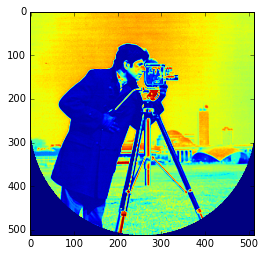

In [18]:
camera = data.camera()
camera[:10] = 0
mask = camera < 87
camera[mask] = 255
nrows, ncols = camera.shape
inds_r = np.arange(len(camera))
inds_c = 4 * inds_r % len(camera)
camera[inds_r, inds_c] = 0
row, col = np.ogrid[:nrows, :ncols]
cnt_row, cnt_col = nrows / 2, ncols / 2
outer_disk_mask = ((row - cnt_row)**2 + (col - cnt_col)**2 > (nrows / 2)**2)
camera[outer_disk_mask] = 0
lower_half = row > cnt_row
lower_half_disk = np.logical_and(lower_half, outer_disk_mask)
camera = data.camera()
camera[lower_half_disk] = 0
plt.imshow(camera)

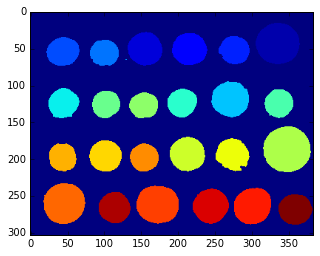

In [45]:
from skimage.feature import canny
from scipy import ndimage as ndi
from skimage.filters import sobel
from skimage.morphology import watershed

coins = data.coins()
histo = np.histogram(coins, bins=np.arange(0, 256))
edges = canny(coins/255.)
fill_coins = ndi.binary_fill_holes(edges)
elevation_map = sobel(coins)
markers = np.zeros_like(coins)
markers[coins < 30] = 1
markers[coins > 150] = 2
segmentation = watershed(elevation_map, markers)
segmentation = ndi.binary_fill_holes(segmentation - 1)
labeled_coins, _ = ndi.label(segmentation)

plt.imshow(labeled_coins)

In [3]:
from skimage import data, color, util
from skimage.restoration import denoise_tv_chambolle
from skimage.feature import hog
from joblib import Parallel, delayed

def task(image):
    """
    Apply some functions and return an image.
    """
    image = denoise_tv_chambolle(image[0][0], weight=0.1, multichannel=True)
    fd, hog_image = hog(color.rgb2gray(image), orientations=8,
                        pixels_per_cell=(16, 16), cells_per_block=(1, 1),
                        visualise=True)
    return hog_image


# Prepare images
hubble = data.hubble_deep_field()
width = 10
pics = util.view_as_windows(hubble, (width, hubble.shape[1], hubble.shape[2]), step=width)

def classic_loop():
    for image in pics:
        task(image)

def comprehension_loop():
    [task(image) for image in pics]
    
def joblib_loop():
    Parallel(n_jobs=4)(delayed(task)(i) for i in pics)

%timeit classic_loop()
%timeit comprehension_loop()
%timeit joblib_loop()

1 loop, best of 3: 3.16 s per loop
1 loop, best of 3: 3.15 s per loop
1 loop, best of 3: 1.19 s per loop


In [4]:
from skimage import data
from skimage.viewer import ImageViewer

image = data.coins()
viewer = ImageViewer(image)
viewer.show()

/usr/local/lib/python3.5/site-packages/skimage/viewer/utils/core.py:10: UserWarning: Recommended matplotlib backend is `Agg` for full skimage.viewer functionality.
  warn("Recommended matplotlib backend is `Agg` for full "


TypeError: connect() failed between NavigationToolbar2QT.message[str] and _show_message()